# Set up Environment

In [147]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.19.0 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


In [209]:
# Make cluster by cluster plots
def plot_by_cluster(adata, clust_key, size=60, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]

    sc.pl.umap(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, legend_loc=legend_loc, **kwargs)

In [182]:
# Map annotations to abbreviated names
def annotation_abbr(annotations):
    tmp = []
    for ann in annotations:
        ann = ann.replace('Natural killer T (NKT) cell','NKT')
        ann = ann.replace('Hematopoietic stem cell','HSC')
        ann = ann.replace('Mesenchymal stem cell','MSC')
        ann = ann.replace('Natural killer cell','NK')
        ann = ann.replace('Embryonic stem cell','ESC')
        ann = ann.replace('Regulatory T (Treg) cell', 'Treg')
        ann = ann.replace(' (Th1)','')
        ann = ann.replace('T helper', 'Th')
        ann = ann.replace(' cell','')
        ann = ann.replace('-','UND')
        tmp.append(ann)
    return tmp

In [185]:
def names_make_unique(annotations):
    ann_dic = {}
    # construct dictionary for all names, cluster indices will be stored for each name
    for i,ann in enumerate(annotations):
        if ann_dic.get(ann)==None:
            ann_dic[ann] = [i]
        else:
            ann_dic[ann].append(i)
    #  
    for ann in ann_dic:
        num = len(ann_dic[ann])
        if num > 1:
            for indx in ann_dic[ann]:
                annotations[indx] = '('+ann+')'+'_'+ str(num)
                num -= 1
    return annotations

## Loading projection coordinates and cluster annotations

In [150]:
combined_tsne = sc.read('/scratch/combined_tsne.h5ad')
combined_umap = sc.read('/scratch/combined_umap.h5ad')

In [186]:
# copy and paste the raw output for umap
umap_annotation_output=[['0', '?', 'T cell|Natural killer cell', '5.689008708265971|4.890021455145594', 1.1633913594141045],
['1', '?', 'Natural killer T (NKT) cell|T helper cell', '4.556586409360605|3.520559304370638', 1.2942791231222208],
['10', '?', 'T cell|Natural killer T (NKT) cell', '6.1376002275267885|5.232904883568479', 1.172885875835253],
['11', 'Good', 'Natural killer T (NKT) cell', 5.484904878564008, 3.5915517109229707],
['12', '?', 'Regulatory T (Treg) cell|T cell', '8.242009593738008|5.700545498811905', 1.4458282273960956],
['13', '?', 'Mesenchymal stem cell|Stem cell', '7.54639570676865|4.025662500919277', 1.8745723728815813],
['14', 'Good', 'Basal cell', 8.865754903441077, 2.527720874090026],
['15', '?', 'Endothelial cell|Mesenchymal stem cell', '9.642962345995112|5.361993611019405', 1.7983912413058292],
['16', '?', 'Astrocyte|Natural killer T (NKT) cell', '4.1426189746107225|3.5192437356355692', 1.1771332950494187],
['17', 'N', '-', '-', '-'],
['18', '?', 'Stem cell|Progenitor cell', '6.779986772870625|3.8814636326430416', 1.746760349846139],
['19', 'Good', 'Microglial cell', 5.380574668603858, 2.359127624998199],
['2', 'Good', 'Microglial cell', 6.709582715957533, 4.423999276970022],
['20', 'Good', 'B cell', 8.22476649375306, 2.741651700666292],
['21', '?', 'Natural killer T (NKT) cell|Hematopoietic stem cell', '6.796384247990113|3.6745424101956567', 1.8495865578071335],
['22', '?', 'Mast cell|Hematopoietic stem cell', '7.309491934519934|4.553262455305115', 1.6053306845959363],
['3', '?', 'Microglial cell|Hematopoietic stem cell', '4.934799841534256|3.255370808489902', 1.5158948494176019],
['4', 'Good', 'B cell', 10.25550100559487, 8.058229297844015],
['5', 'N', '-', '-', '-'],
['6', 'Good', 'B cell', 9.122142424756449, 2.1931877410450316],
['7', '?', 'Natural killer cell|Natural killer T (NKT) cell', '5.783215030198831|4.673850458337509', 1.237355598290991],
['8', '?', 'Basal cell|Embryonic stem cell', '6.113579618443279|4.4504870888465105', 1.3736877551593603],
['9', '?', 'Natural killer T (NKT) cell|T helper1 (Th1) cell', '4.398325047140241|4.322055475048344', 1.017646597211028]]

# extract annotations
umap_cluster_names = [None for _ in range(len(umap_annotation_output))]
for annotation in umap_annotation_output:
    index = int(annotation[0])
    name = annotation[2]
    umap_cluster_names[index] = name
    
umap_cluster_names = annotation_abbr(umap_cluster_names)
umap_cluster_names = names_make_unique(umap_cluster_names)

In [187]:
# View cluster annotations and get the number of labels that needs extra attention
for i,name in enumerate(umap_cluster_names):
    print((i,name))
print('Need to make labels unique for {} of the clusters'.format(len(umap_cluster_names)-len(set(umap_cluster_names))))

(0, 'T|NK')
(1, 'NKT|Th')
(2, '(Microglial)_2')
(3, 'Microglial|HSC')
(4, '(B)_3')
(5, '(UND)_2')
(6, '(B)_2')
(7, 'NK|NKT')
(8, 'Basal|ESC')
(9, 'NKT|Th1')
(10, 'T|NKT')
(11, 'NKT')
(12, 'Treg|T')
(13, 'MSC|Stem')
(14, 'Basal')
(15, 'Endothelial|MSC')
(16, 'Astrocyte|NKT')
(17, '(UND)_1')
(18, 'Stem|Progenitor')
(19, '(Microglial)_1')
(20, '(B)_1')
(21, 'NKT|HSC')
(22, 'Mast|HSC')
Need to make labels unique for 0 of the clusters


In [188]:
# copy and paste the raw output for umap
tsne_annotation_output = [['0', '?', 'T cell|Natural killer cell', '5.689008708265971|4.890021455145594', 1.1633913594141045],
['1', '?', 'Natural killer T (NKT) cell|T helper cell', '4.556586409360605|3.520559304370638', 1.2942791231222208],
['10', '?', 'T cell|Natural killer T (NKT) cell', '6.1376002275267885|5.232904883568479', 1.172885875835253],
['11', 'Good', 'Natural killer T (NKT) cell', 5.484904878564008, 3.5915517109229707],
['12', '?', 'Regulatory T (Treg) cell|T cell', '8.242009593738008|5.700545498811905', 1.4458282273960956],
['13', '?', 'Mesenchymal stem cell|Stem cell', '7.54639570676865|4.025662500919277', 1.8745723728815813],
['14', 'Good', 'Basal cell', 8.865754903441077, 2.527720874090026],
['15', '?', 'Endothelial cell|Mesenchymal stem cell', '9.642962345995112|5.361993611019405', 1.7983912413058292],
['16', '?', 'Astrocyte|Natural killer T (NKT) cell', '4.1426189746107225|3.5192437356355692', 1.1771332950494187],
['17', 'N', '-', '-', '-'],
['18', '?', 'Stem cell|Progenitor cell', '6.779986772870625|3.8814636326430416', 1.746760349846139],
['19', 'Good', 'Microglial cell', 5.380574668603858, 2.359127624998199],
['2', 'Good', 'Microglial cell', 6.709582715957533, 4.423999276970022],
['20', 'Good', 'B cell', 8.22476649375306, 2.741651700666292],
['21', '?', 'Natural killer T (NKT) cell|Hematopoietic stem cell', '6.796384247990113|3.6745424101956567', 1.8495865578071335],
['22', '?', 'Mast cell|Hematopoietic stem cell', '7.309491934519934|4.553262455305115', 1.6053306845959363],
['3', '?', 'Microglial cell|Hematopoietic stem cell', '4.934799841534256|3.255370808489902', 1.5158948494176019],
['4', 'Good', 'B cell', 10.25550100559487, 8.058229297844015],
['5', 'N', '-', '-', '-'],
['6', 'Good', 'B cell', 9.122142424756449, 2.1931877410450316],
['7', '?', 'Natural killer cell|Natural killer T (NKT) cell', '5.783215030198831|4.673850458337509', 1.237355598290991],
['8', '?', 'Basal cell|Embryonic stem cell', '6.113579618443279|4.4504870888465105', 1.3736877551593603],
['9', '?', 'Natural killer T (NKT) cell|T helper1 (Th1) cell', '4.398325047140241|4.322055475048344', 1.017646597211028]]

# extract annotations
tsne_cluster_names = [None for _ in range(len(tsne_annotation_output))]
for annotation in tsne_annotation_output:
    index = int(annotation[0])
    name = annotation[2]
    tsne_cluster_names[index] = name
    
tsne_cluster_names = annotation_abbr(tsne_cluster_names)
tsne_cluster_names = names_make_unique(tsne_cluster_names)

# TSNE plots with annotations

In [189]:
print('Cluster Type')
for num,type in enumerate(tsne_cluster_names):
    print((num,type))

Cluster Type
(0, 'T|NK')
(1, 'NKT|Th')
(2, '(Microglial)_2')
(3, 'Microglial|HSC')
(4, '(B)_3')
(5, '(UND)_2')
(6, '(B)_2')
(7, 'NK|NKT')
(8, 'Basal|ESC')
(9, 'NKT|Th1')
(10, 'T|NKT')
(11, 'NKT')
(12, 'Treg|T')
(13, 'MSC|Stem')
(14, 'Basal')
(15, 'Endothelial|MSC')
(16, 'Astrocyte|NKT')
(17, '(UND)_1')
(18, 'Stem|Progenitor')
(19, '(Microglial)_1')
(20, '(B)_1')
(21, 'NKT|HSC')
(22, 'Mast|HSC')


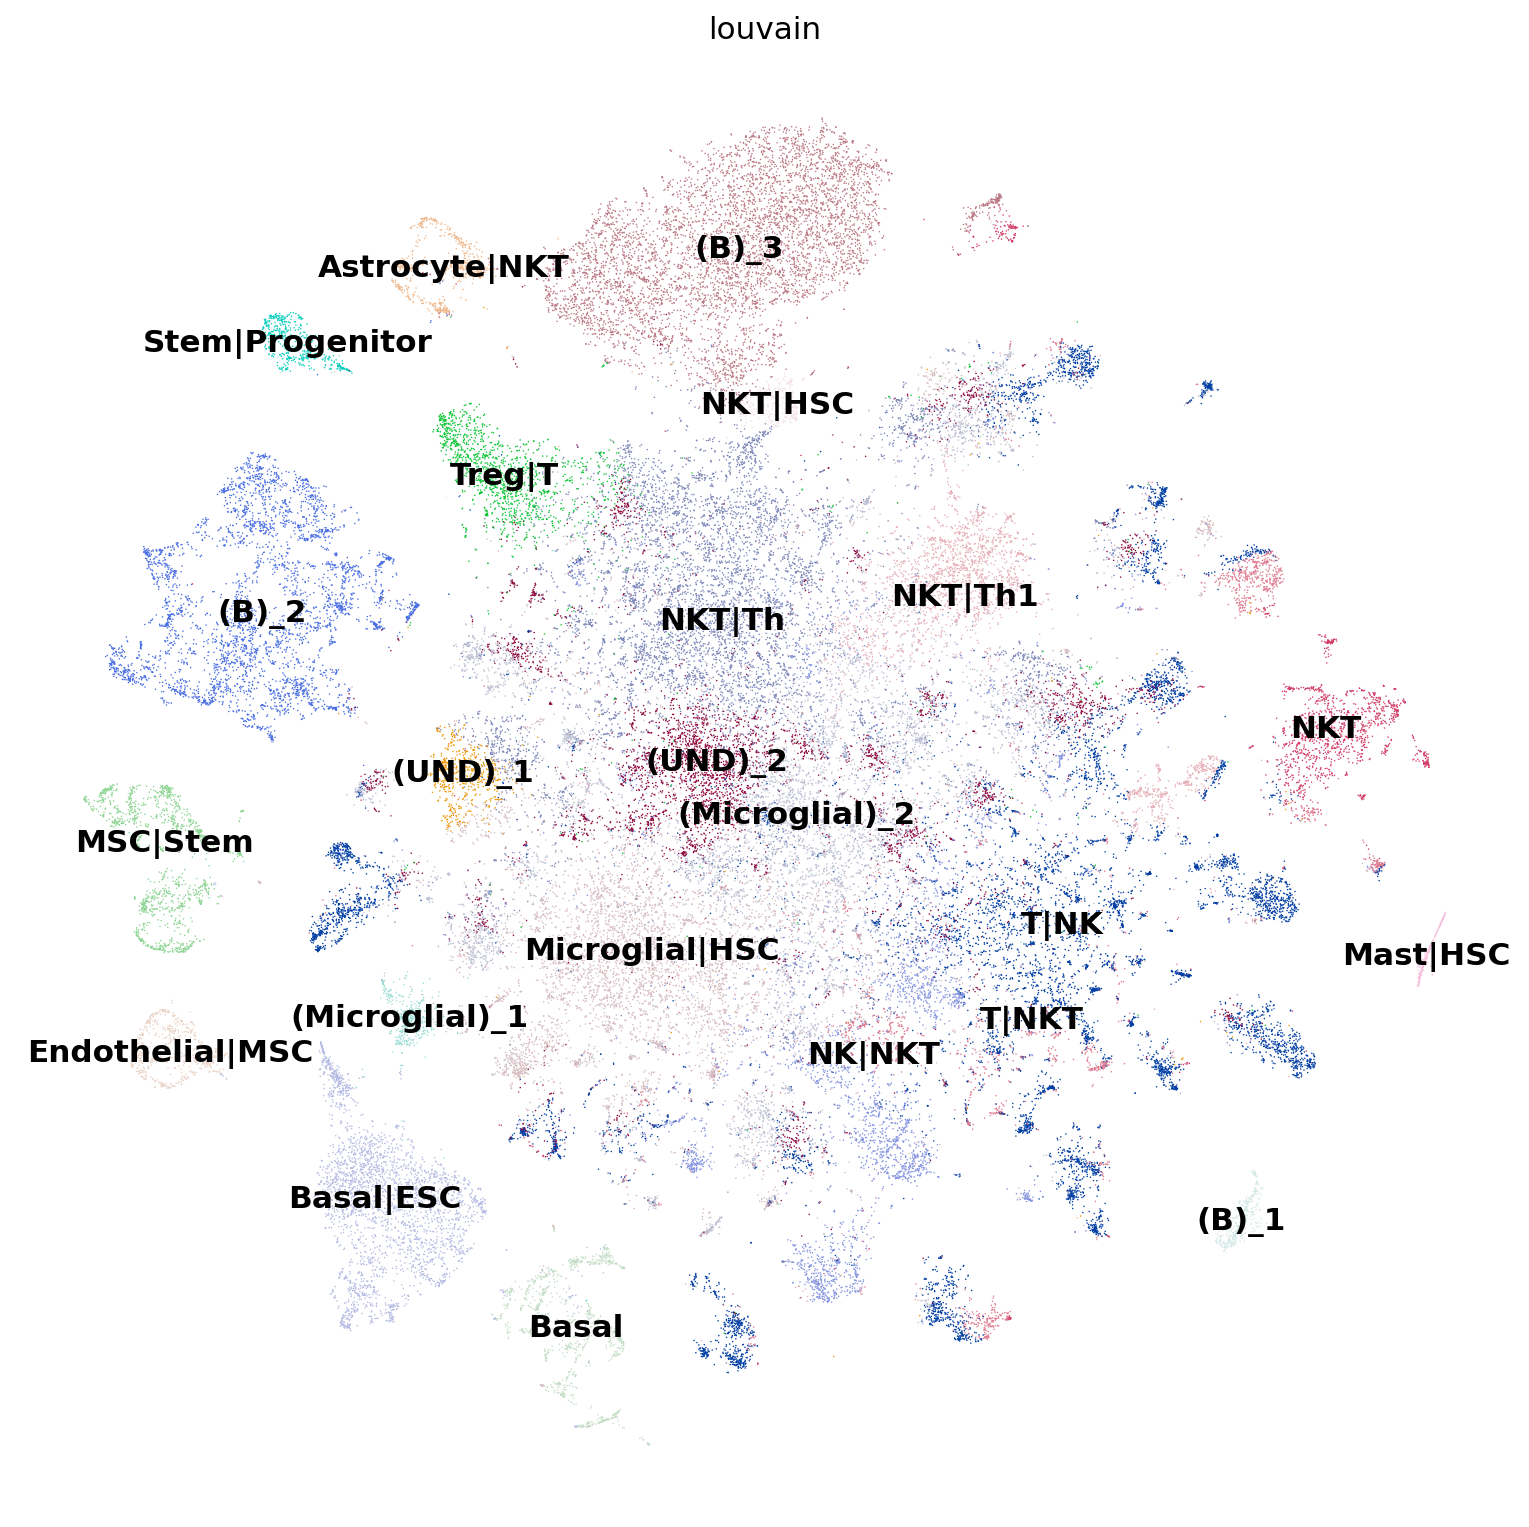

In [190]:
combined_tsne.rename_categories('louvain', tsne_cluster_names)
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.tsne(combined_tsne, color='louvain', frameon=False,legend_loc='on data',ax=ax)

## Marker Genes for TSNE Clusters
#### Note that here the genes are selected based on gene score which leverages both adjusted p-value and log-fold-change. Since all the p-values for top 5 genes do not have any numerical significance (below machine limit), we don't list them here.

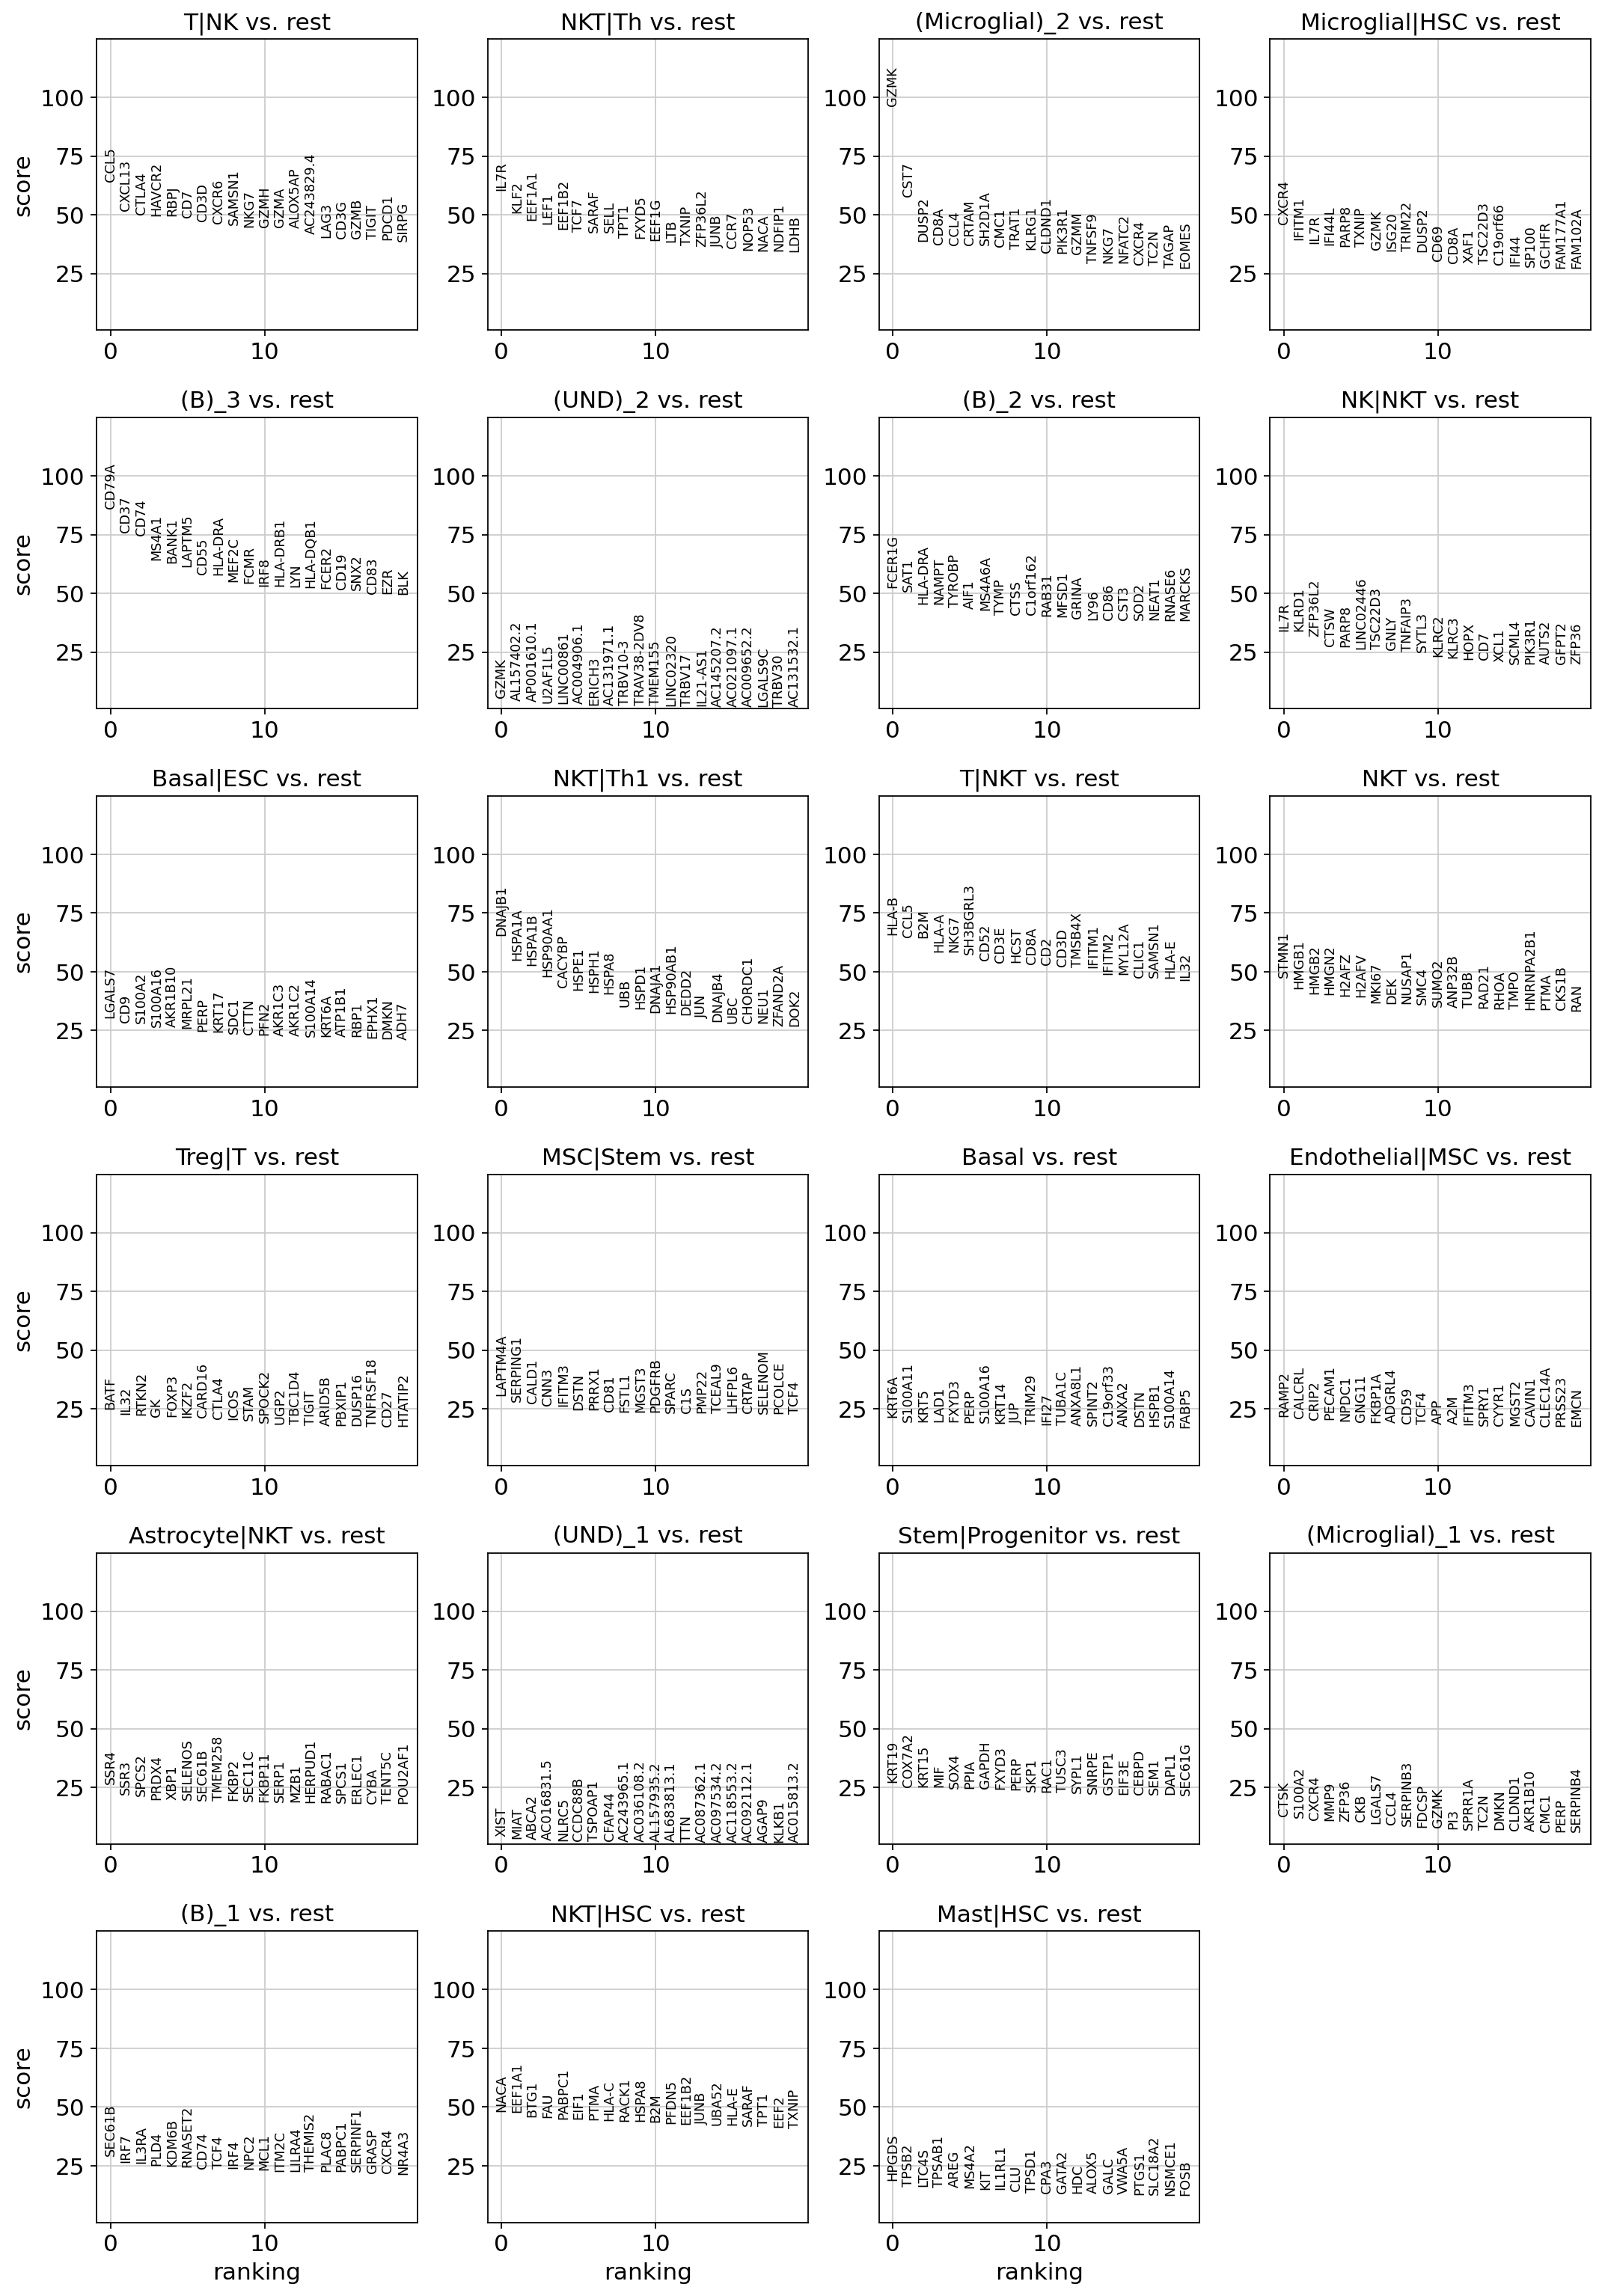

In [212]:
sc.pl.rank_genes_groups(combined_tsne)

# UMAP plots with annotations

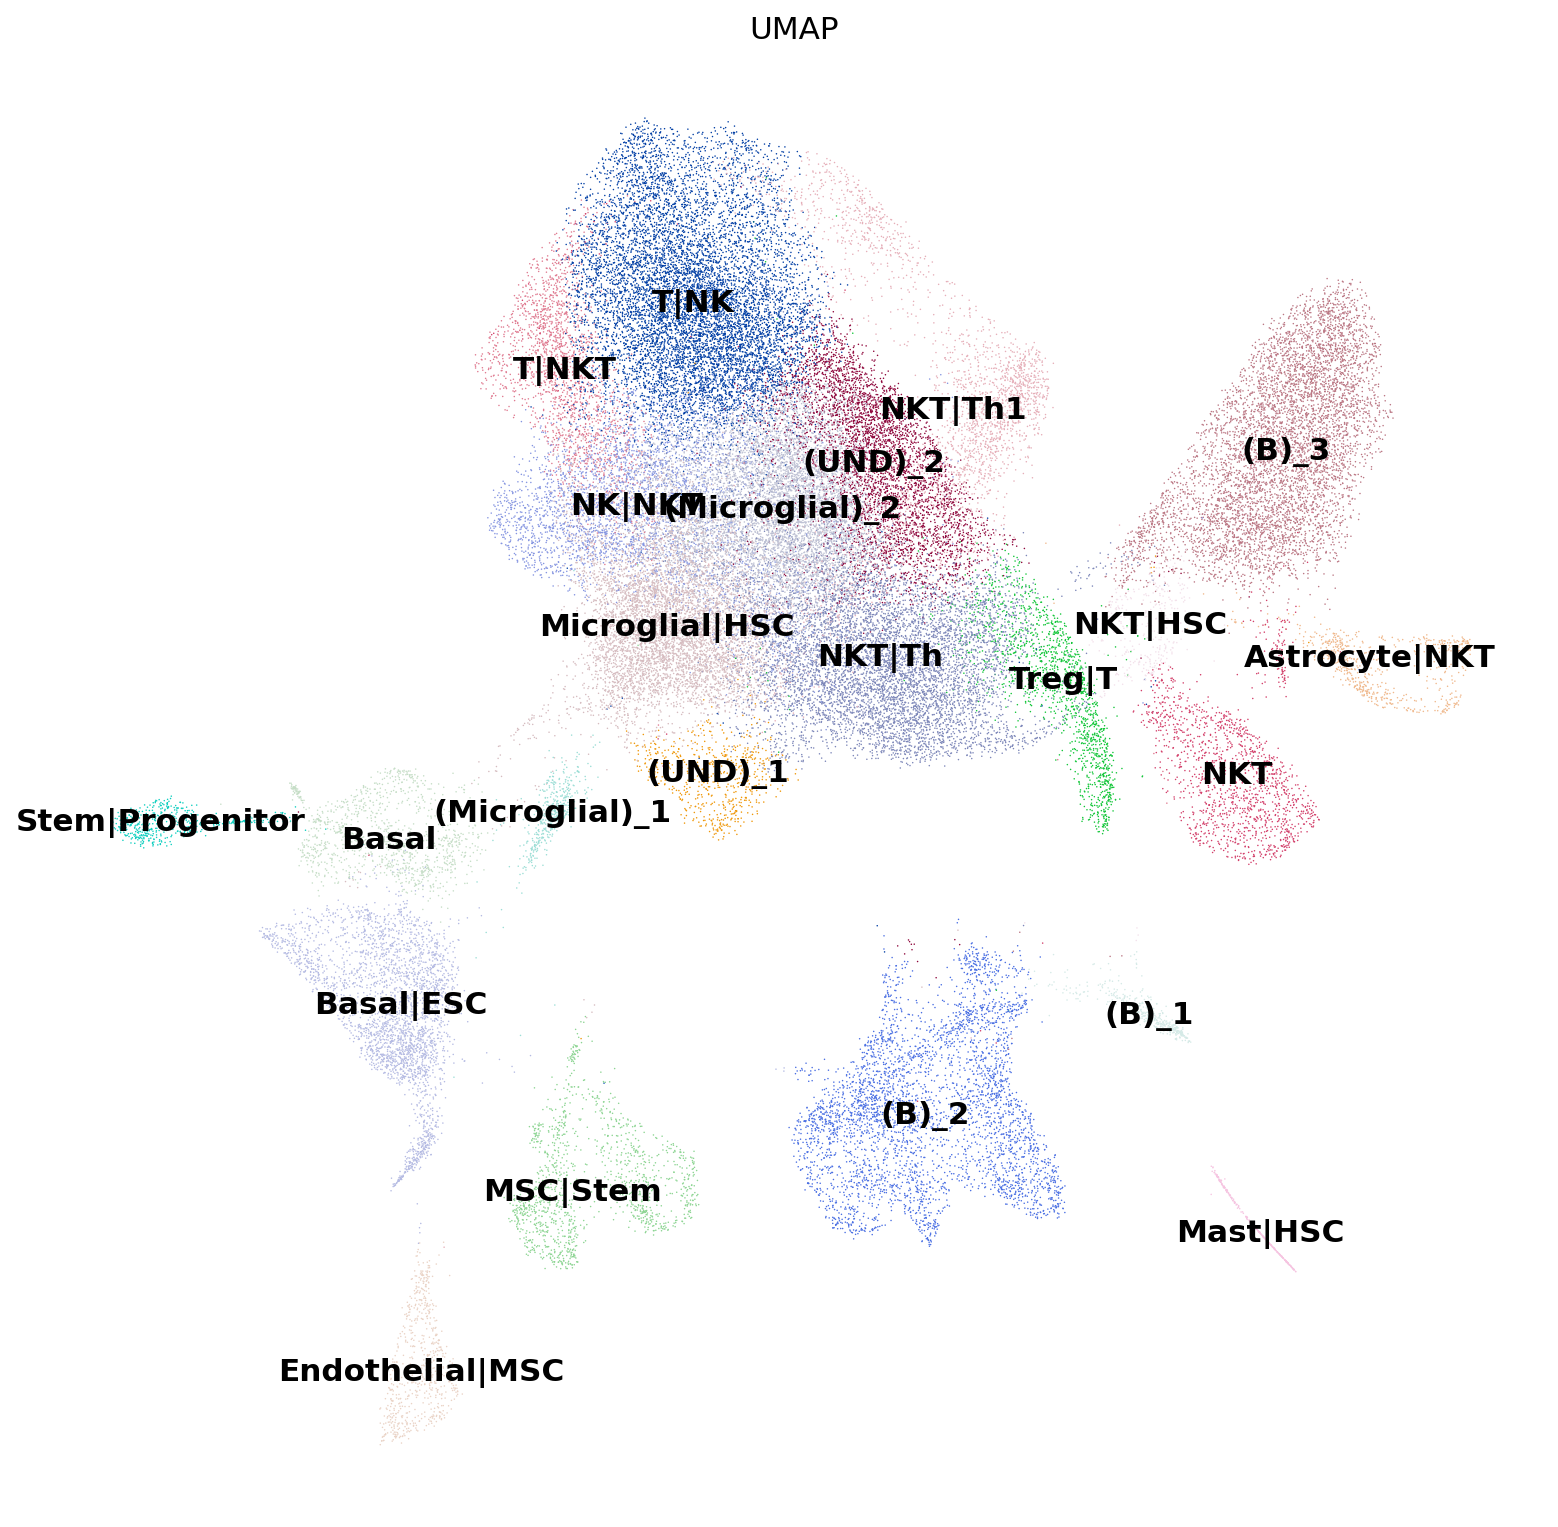

In [193]:
combined_umap.rename_categories('louvain', umap_cluster_names)
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.umap(combined_umap, color='louvain', title='UMAP', legend_loc='on data',frameon=False,ax=ax)

## Marker Genes for UMAP Clusters
#### Note that here the genes are selected based on gene score which leverages both adjusted p-value and log-fold-change. Since all the p-values for top 5 genes do not have any numerical significance (below machine limit), we don't list them here.

#### For the undetermined clusters:
#### (UND)_2: GZMK, TCAV, TCBV ==> T cell?
#### (UND)_1: CCDC88B, NLRC5 ==> ??

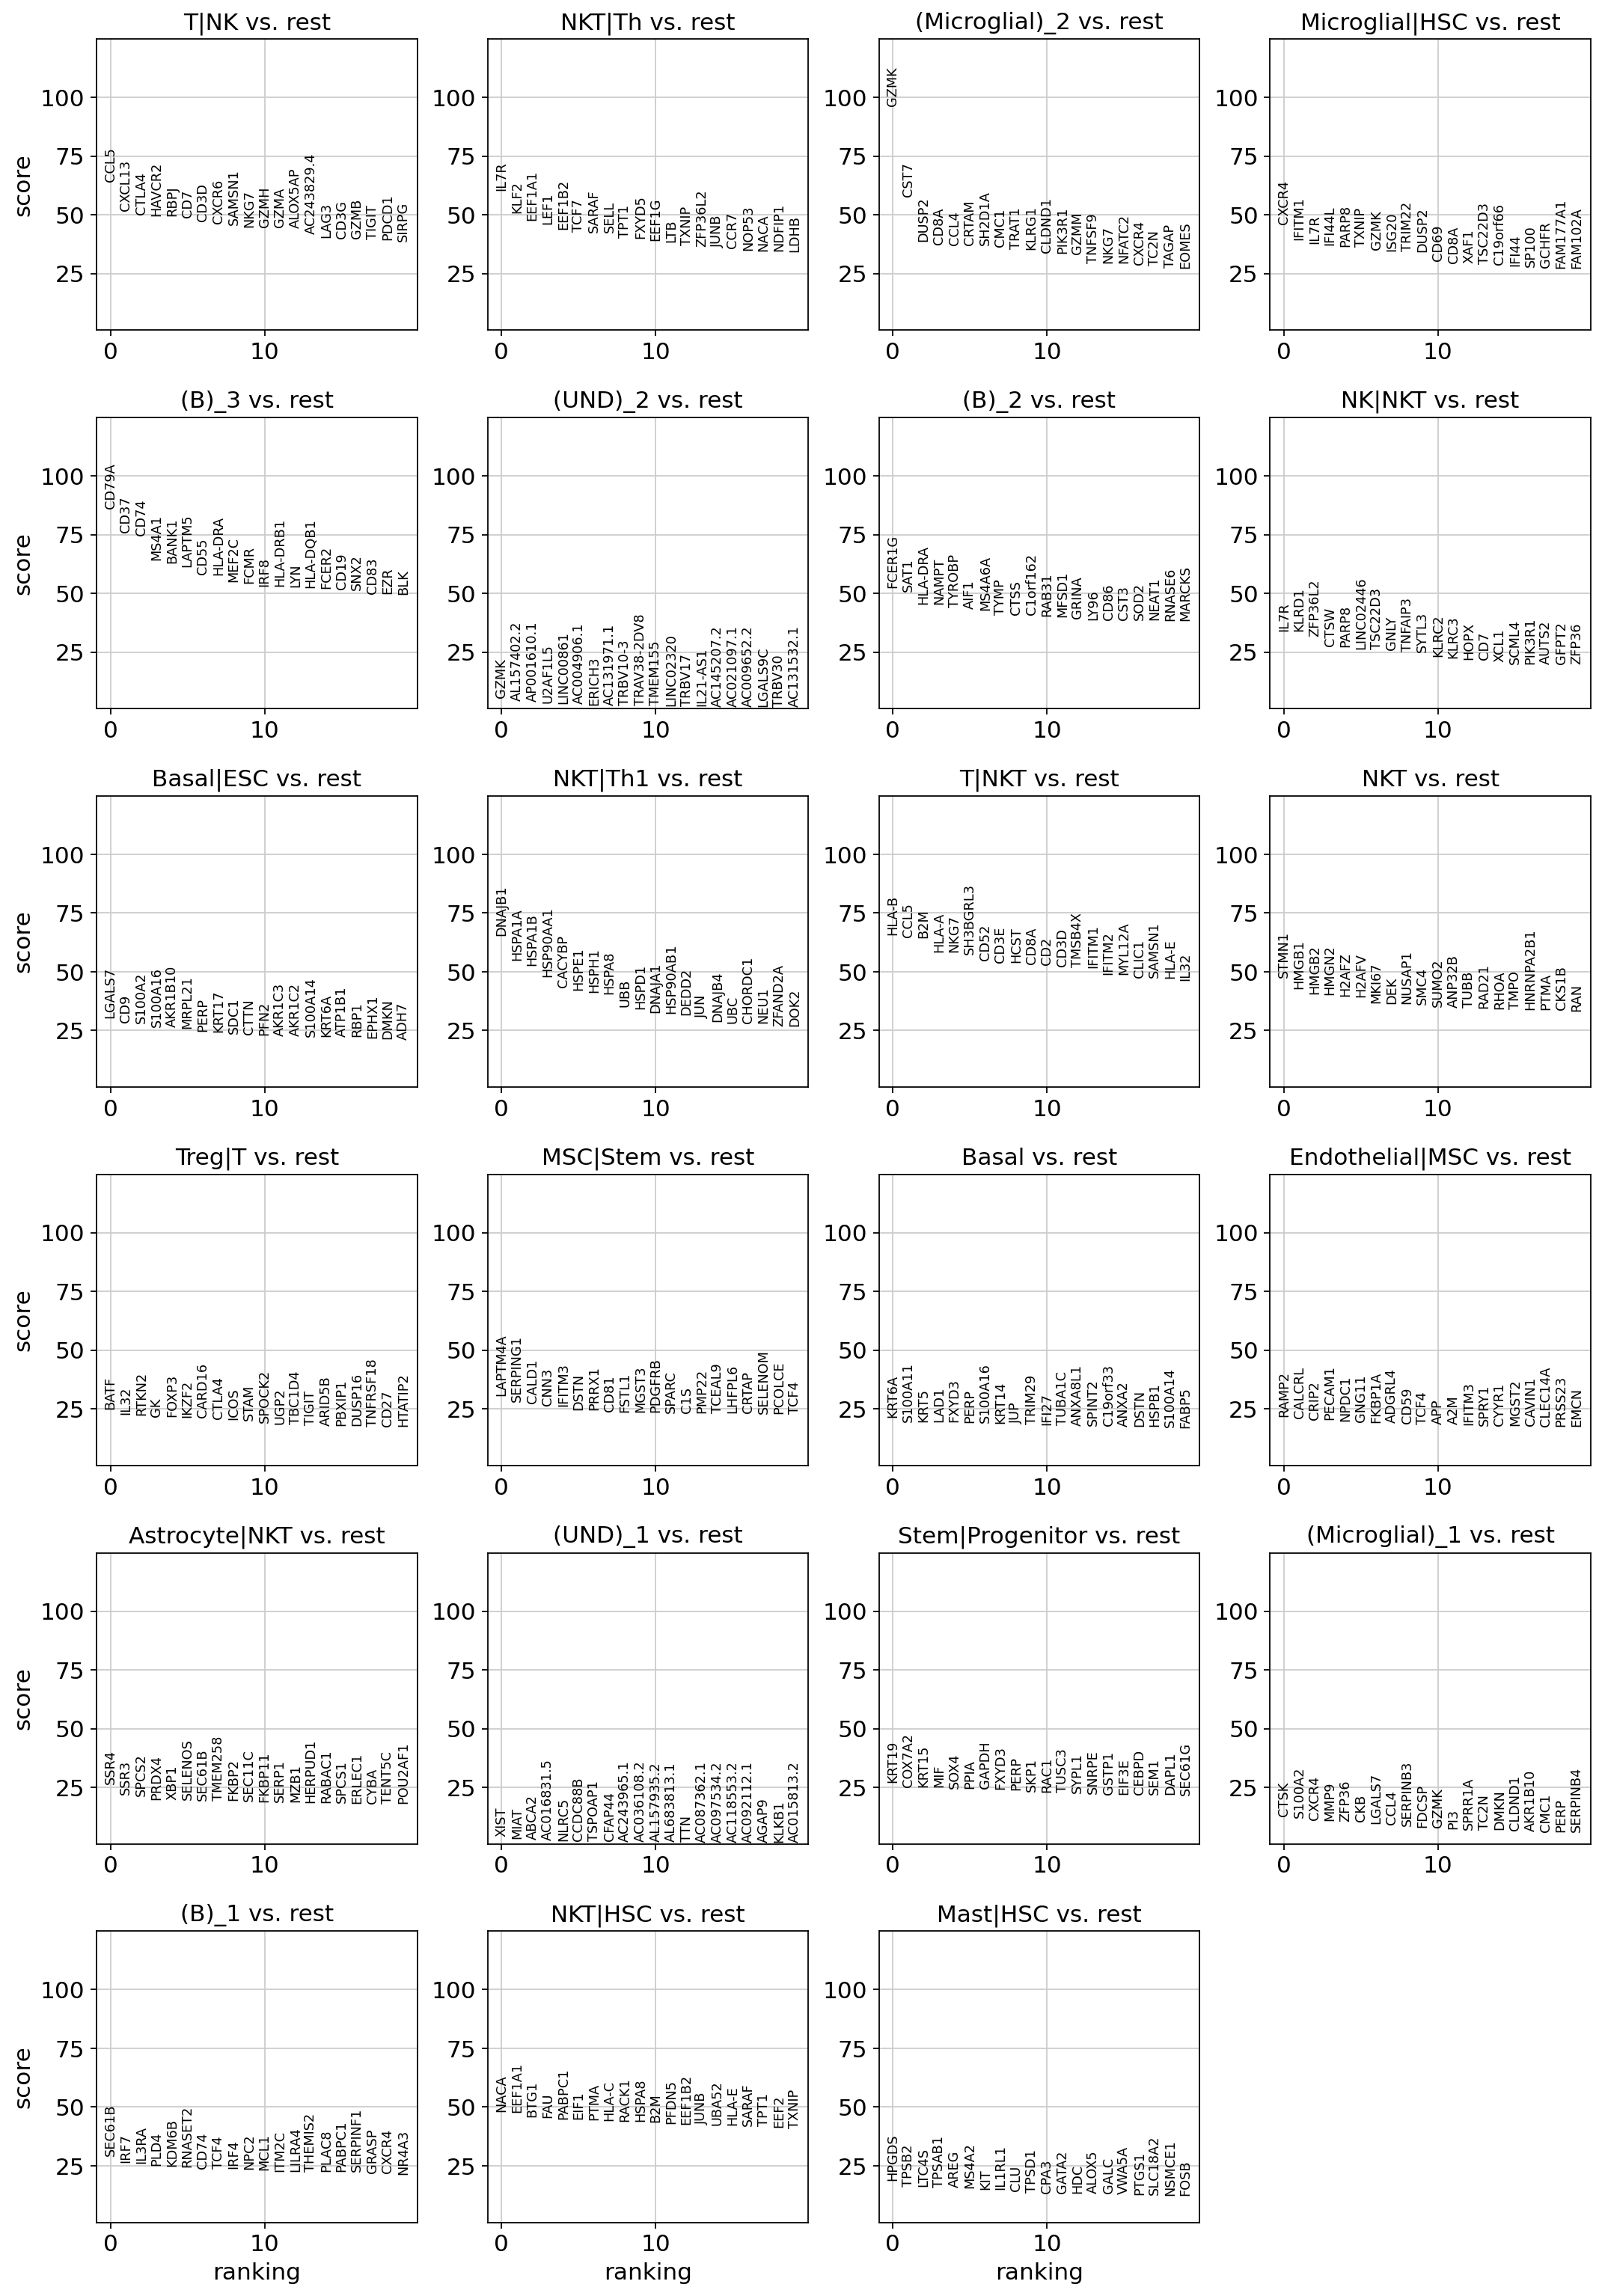

In [195]:
sc.pl.rank_genes_groups(combined_umap)

In [211]:
#print("Format: (gene_name, log_fold_change)")
#print('\n')

#top_n = 20 # the number of top marker genes displayed

#for i in range(len(umap_cluster_names)):
#    print(umap_cluster_names[i])
#    print(tuple(zip((combined_umap.uns['rank_genes_groups']['names'][i][j] for j in range(top_n)),
#                    (combined_umap.uns['rank_genes_groups']['logfoldchanges'][i][j] for j in range(top_n)))))
#    print('\n')